
# Exercise 2: Word2Vec-style embeddings to RNN encoder for text classification

**Indicative completion time:** 90–120 minutes  
**WLO alignment:** WLO1, WLO2, introductory WLO3  
**Last updated:** 2025-09-22 15:53 UTC

This exercise takes you from predictive embeddings to a simple sequence encoder for document classification.  
Because `gensim` may not be available in your environment, we will use **spaCy's pretrained vectors** (`en_core_web_md`) as a practical substitute for Word2Vec-style embeddings. You will:
1) prepare a small two-class dataset,
2) explore nearest neighbours and a 2D projection of the embedding space,
3) build an averaged-embedding baseline classifier,
4) build a compact RNN encoder classifier initialised with spaCy vectors,
5) evaluate, compare and reflect.



## 0. Setup

If you are on **Google Colab**, run the cell below to install dependencies. If the model download is slow, you may choose to skip spaCy vectors and fall back to GloVe via torchtext in the optional cell.


In [20]:
# Colab setup (no PyTorch install). Fixes the deprecated pkgutil.find_loader warning.

import sys, subprocess, importlib.util

def pip_install(pkgs):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)

# spaCy core
if importlib.util.find_spec("spacy") is None:
    pip_install(["spacy==3.7.4"])
import spacy

# spaCy model
try:
    nlp = spacy.load("en_core_web_md")
except Exception:
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_md"])
    nlp = spacy.load("en_core_web_md")

# Other libs (avoid installing torch; use Colab’s built-in)
pip_install(["scikit-learn==1.5.1", "pandas==2.2.2", "matplotlib==3.9.0", "tqdm==4.66.5"])

print("spaCy:", spacy.__version__)
print("Vectors dim:", nlp.vocab.vectors_length)


spaCy: 3.8.7
Vectors dim: 300


In [21]:

#@title Optional fallback: Use torchtext GloVe if spaCy vectors are unavailable
# from torchtext.vocab import GloVe
# glove = GloVe(name="6B", dim=100)  # downloads ~80MB
# def glove_vec(w): return glove.get_vecs_by_tokens(w, lower_case_backup=True).numpy()



## 1. Load and sample data

We will use two categories from 20 Newsgroups to keep training fast. You can change categories if you wish.


In [22]:

import pandas as pd
from sklearn.datasets import fetch_20newsgroups

cats = ['rec.autos','sci.electronics']
data = fetch_20newsgroups(subset='train', categories=cats, remove=('headers','footers','quotes'))
df = pd.DataFrame({'text': data.data, 'label': data.target}).sample(n=1000, random_state=0)
df.head()


,text,label
833,\n\nsure sounds like they got a ringer. the 3...,0
567,\n\n\nI dont know about the car comparison but...,0
950,Hi: I'd like to know how much the foll. equipm...,1
922,Sci.E(E) netters:\n\nI am setting out to build...,1
362,\n\n \n I'd like any accumulated inform...,1



## 2. Preprocess and tokenise

**TODO:** Choose simple preprocessing that remains comparable across models.  
Suggested: lowercasing and spaCy tokenisation with alphabetic filtering and min length.


In [23]:

# Tokenise with spaCy; keep simple rules for clarity.
import re
import spacy
nlp = spacy.load("en_core_web_md", disable=["tagger","parser","ner","lemmatizer","attribute_ruler"])

def tokenize(doc, min_len=2):
    doc = nlp.make_doc(doc.lower())
    return [t.text for t in doc if t.is_alpha and len(t.text) >= min_len]

# Build tokenised corpus
df["tokens"] = [tokenize(t) for t in df["text"]]
df[["text","tokens","label"]].head()


,text,tokens,label
833,\n\nsure sounds like they got a ringer. the 3...,"[sure, sounds, like, they, got, ringer, the, d...",0
567,\n\n\nI dont know about the car comparison but...,"[do, nt, know, about, the, car, comparison, bu...",0
950,Hi: I'd like to know how much the foll. equipm...,"[hi, like, to, know, how, much, the, foll, equ...",1
922,Sci.E(E) netters:\n\nI am setting out to build...,"[netters, am, setting, out, to, build, and, ma...",1
362,\n\n \n I'd like any accumulated inform...,"[like, any, accumulated, information, on, this...",1



## 3. Build vocabulary and embedding matrix from spaCy vectors

We will include tokens that have vectors in `en_core_web_md`. OOV handling can be zero vectors or ignored tokens.

**TODO:** Decide whether to drop OOV tokens or map them to a learned `<unk>` vector.


In [24]:

from collections import Counter
import numpy as np

# Build vocab from tokens that have vectors
counter = Counter(tok for toks in df["tokens"] for tok in toks)
min_freq = 2  #@param {type:"integer"}
itos = ["<pad>", "<unk>"]
for tok, c in counter.items():
    if c >= min_freq and nlp.vocab.has_vector(tok):
        itos.append(tok)
stoi = {w:i for i,w in enumerate(itos)}

vocab_size = len(itos)
emb_dim = nlp.vocab.vectors_length

# Embedding matrix initialised from spaCy
emb_matrix = np.zeros((vocab_size, emb_dim), dtype="float32")
unk_vec = np.random.normal(scale=0.6, size=(emb_dim,)).astype("float32")

for i, w in enumerate(itos):
    if w in ("<pad>", "<unk>"):
        continue
    emb_matrix[i] = nlp.vocab.get_vector(w)

emb_matrix[stoi["<unk>"]] = unk_vec

def encode_tokens(toks, max_len=None):
    ids = [stoi.get(w, stoi["<unk>"]) for w in toks if w in stoi]
    return ids[:max_len] if max_len else ids

vocab_size, emb_dim


(5737, 300)


## 4. Explore nearest neighbours

Pick several probe terms relevant to the classes and print their nearest neighbours by cosine similarity.

**TODO:** Replace the default probes with your own domain-relevant words.


In [25]:

from numpy.linalg import norm

def nearest_neighbours(query, topk=10):
    if query not in stoi:
        return []
    qv = emb_matrix[stoi[query]]
    sims = emb_matrix @ qv / (norm(emb_matrix, axis=1) * norm(qv) + 1e-8)
    idx = np.argsort(-sims)[:topk+1]
    return [(itos[i], float(sims[i])) for i in idx if itos[i] != query][:topk]

probes = ["car","engine","battery","circuit","voltage","dealer","warranty","sensor"]
for p in probes:
    print(f"Probe: {p}")
    print(nearest_neighbours(p, topk=8))
    print("-"*60)


Probe: car
[('inexpensive', 0.9999999403953552), ('luxury', 0.9999999403953552), ('hotel', 0.9999999403953552), ('cheap', 0.9999999403953552), ('buy', 0.9999999403953552), ('cheapest', 0.9999999403953552), ('outlet', 0.7889221906661987), ('shop', 0.7889221906661987)]
------------------------------------------------------------
Probe: engine
[('engines', 1.0), ('services', 0.5324414968490601), ('delivering', 0.5324414968490601), ('automotive', 0.5324414968490601), ('product', 0.5324414968490601), ('leading', 0.5324414968490601), ('products', 0.5324414968490601), ('platform', 0.5324414372444153)]
------------------------------------------------------------
Probe: battery
[('mains', 1.0000001192092896), ('charge', 1.0000001192092896), ('duty', 1.0), ('charging', 1.0), ('arrange', 1.0), ('plug', 1.0), ('carrying', 1.0), ('phone', 1.0)]
------------------------------------------------------------
Probe: circuit
[('sinusoidal', 1.0000001192092896), ('pulses', 1.0000001192092896), ('polarity'


## 5. Visualise the embedding space (PCA)

Plot a 2D projection for probe words and their neighbours to inspect semantic clustering.


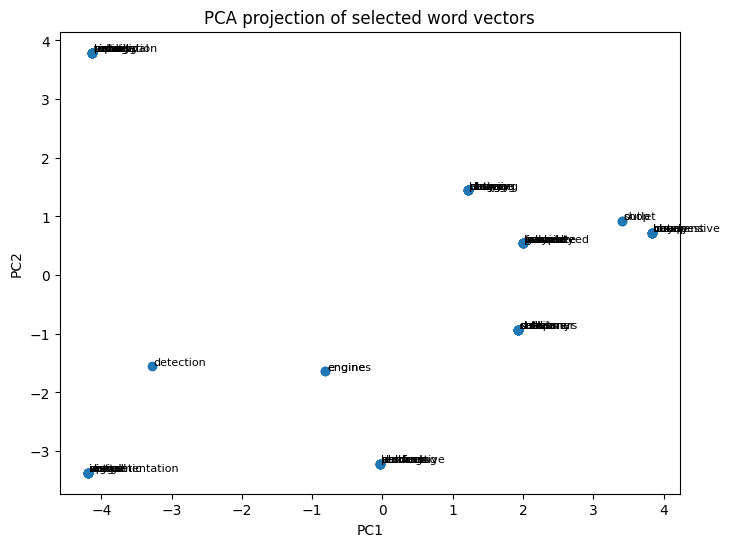

In [26]:

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

plot_words = set()
for p in probes:
    plot_words.add(p)
    for w,_ in nearest_neighbours(p, topk=8):
        plot_words.add(w)
plot_words = [w for w in plot_words if w in stoi][:120]

X = np.stack([emb_matrix[stoi[w]] for w in plot_words])
p2 = PCA(n_components=2).fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(p2[:,0], p2[:,1])
for (x,y), w in zip(p2, plot_words):
    plt.text(x+0.02, y+0.02, w, fontsize=8)
plt.title("PCA projection of selected word vectors")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()



## 6. Baseline classifier: averaged embeddings

Create a document vector by averaging in-vocab word vectors. Train a simple classifier and evaluate.

**TODO:** Choose metrics. Record accuracy and macro F1 at minimum.


In [27]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import numpy as np

def doc_vector(toks):
    vecs = [emb_matrix[stoi.get(w, stoi["<unk>"])] for w in toks if w in stoi]
    if not vecs:
        return np.zeros((emb_dim,), dtype="float32")
    return np.mean(vecs, axis=0)

X = np.stack([doc_vector(t) for t in df["tokens"]])
y = df["label"].values

X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf = LogisticRegression(max_iter=200)
clf.fit(X_tr, y_tr)
pred = clf.predict(X_va)
acc = accuracy_score(y_va, pred)
f1m = f1_score(y_va, pred, average="macro")
print(f"Baseline (avg embeddings) | acc={acc:.3f} | f1_macro={f1m:.3f}")
print(confusion_matrix(y_va, pred))


Baseline (avg embeddings) | acc=0.810 | f1_macro=0.809
[[87 14]
 [24 75]]



## 7. RNN encoder classifier (PyTorch)

Build a compact LSTM or GRU classifier using the final hidden state as the document representation, initialised with the spaCy embedding matrix.

**TODO:** Choose model type, sequence length, batch size, epochs, and whether to freeze or fine-tune embeddings.


In [28]:
import torch.nn as nn

In [29]:
# Build model as before
model = RNNEncoder(emb_matrix, hidden=hidden, bidir=bidir,
                   cell=cell_type, freeze_emb=freeze_embeddings).to(device)

# ---- Minimal optimiser that avoids torch.optim and torch._dynamo ----
class SGD:
    def __init__(self, params, lr=1e-2, weight_decay=0.0):
        self.params = [p for p in params if p.requires_grad]
        self.lr = lr
        self.wd = weight_decay
    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()
    @torch.no_grad()
    def step(self):
        for p in self.params:
            if p.grad is None:
                continue
            if self.wd:
                p.grad.add_(self.wd, p)  # L2
            p.add_( -self.lr * p.grad )

# Loss and optimiser
crit = nn.CrossEntropyLoss()
opt = SGD(model.parameters(), lr=1e-2, weight_decay=0.0)

# ---- Train ----
epochs = 2  #@param {type:"integer"}
for ep in range(1, epochs+1):
    model.train()
    tr_loss = 0.0
    for xb, yb in tqdm(train_dl, leave=False):
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        logits = model(xb)
        loss = crit(logits, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        tr_loss += loss.item() * len(xb)

    # Validate
    model.eval()
    preds, gold = [], []
    with torch.no_grad():
        for xb, yb in valid_dl:
            xb = xb.to(device)
            logits = model(xb)
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy().tolist())
            gold.extend(yb.numpy().tolist())

    from sklearn.metrics import accuracy_score, f1_score
    acc_rnn = accuracy_score(gold, preds)
    f1m_rnn = f1_score(gold, preds, average="macro")
    print(f"Epoch {ep:02d} | val acc={acc_rnn:.3f} | f1_macro={f1m_rnn:.3f}")


NameError: name 'RNNEncoder' is not defined


## 8. Compare results and visualise errors


In [ ]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

# Baseline metrics were computed earlier as acc and f1m
baseline_acc, baseline_f1 = acc, f1m  # from the earlier baseline cell

# Recompute RNN metrics on validation set to capture final state
model.eval()
preds, gold = [], []
with torch.no_grad():
    for xb, yb in valid_dl:
        xb = xb.to(device)
        logits = model(xb)
        preds.extend(torch.argmax(logits, dim=1).cpu().numpy().tolist())
        gold.extend(yb.numpy().tolist())

rnn_acc = accuracy_score(gold, preds)
rnn_f1 = f1_score(gold, preds, average="macro")

results = pd.DataFrame([
    {"model": "avg-embeddings + LogisticRegression", "accuracy": baseline_acc, "f1_macro": baseline_f1},
    {"model": f"{cell_type.upper()} encoder", "accuracy": rnn_acc, "f1_macro": rnn_f1},
])
results


,model,accuracy,f1_macro
0,avg-embeddings + LogisticRegression,0.810,0.809314
1,LSTM encoder,0.505,0.368441


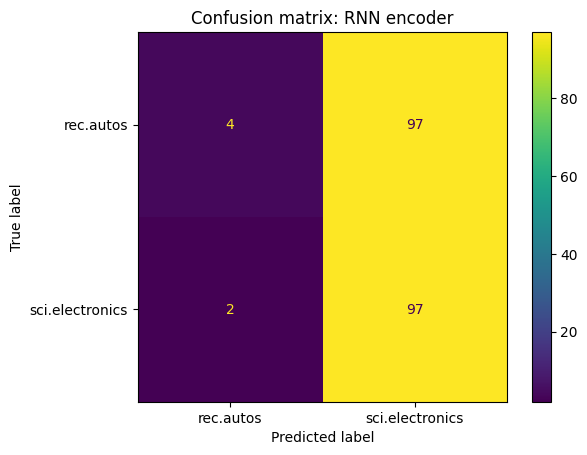

In [ ]:

cm = confusion_matrix(gold, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['rec.autos','sci.electronics'])
disp.plot(values_format='d')
plt.title("Confusion matrix: RNN encoder")
plt.show()



## 9. Short reflection (120–180 words)

**TODO:** Discuss
- When and why did using pretrained vectors improve over a counts baseline in your setting.  
- What did the RNN encoder add beyond averaging.  
- What limitations did you observe that motivate encoder–decoder with attention in future work.
